In [1]:
from sherpa.stats import LeastSq, Chi2
from sherpa.fit import Fit
from sherpa.optmethods import LevMar
from sherpa.estmethods import Covariance
from sherpa.data import Data1D, Data1DInt, Data2D, Data2DInt, DataSimulFit
from sherpa.models import UserModel
from sherpa.models import Parameter, SimulFitModel
from collections import defaultdict

In [85]:
class SherpaFitter(object):

    def __init__(self, statfunc=LeastSq(), method=LevMar(), estmethod=Covariance()):
        self._statfunc = statfunc
        self._optmethod = method

    @staticmethod
    def _astropy2sherpa_model(model):
        def calc2call(func):
            # This decorator makes call and calc work together.
            def _converter(inp, x):
                startp = func._parameters[:]
                func._parameters = np.array(inp)
                retvals = func.__call__(x).ravel()
                func._parameters = startp
                return retvals
            return _converter

        pars = []
        for pname in model.param_names:
            param = model.__getattribute__(pname)
            vals = [param.name, param.value, param.min, param.max, param.min,
                    param.max, None, param.fixed or param.tied, param.fixed or param.tied]
            attrnames = "name,val,min,max,hard_min,hard_max,units,frozen,alwaysfrozen".split(
                ",")
            if model.name is None:
                model._name = ""
            pars.append(Parameter(modelname="wrap_" + model.name, **
                                  dict([(atr, val) for atr, val in zip(attrnames, vals) if val is not None])))

        smodel = UserModel(model.name, pars)
        smodel.calc = calc2call(model)

        return smodel

    def __call__(self, model, x, y, z=None, yerr=None, xerr=None, zerr=None):
        def _iterTranspose(array):  # this takes each element from the dstack and transposes back into columns
            for x in array:
                yield x.T
        x = np.asarray(x)
        y = np.asarray(y)

        if (z is None and model.n_inputs > 1) or (z is not None and model.n_inputs == 1):
            raise Exception("Model and data dimentions don't match")

        if z is None:
            assert x.shape == y.shape, "shape of x and y don't match"
        else:
            z = np.asarray(z)
            assert x.shape == y.shape == z.shape, "shapes x,y and z don't match"

        if yerr is not None:
            yerr = np.array(yerr)
            assert y.shape == yerr.shape, "y's and yerr's shapes do not match"

        if xerr is not None:
            xerr = np.array(xerr)
            assert x.shape == xerr.shape, "x's and xerr's shapes do not match"

        if z is not None and zerr is not None:
            zerr = np.array(zerr)
            assert z.shape == zerr.shape, "z's and zerr's shapes do not match"

        self._data = []

        if z is None:
            if xerr is None:
                if yerr is None:
                    for xx, yy in _iterTranspose(np.dstack((x, y))):
                        self._data.append(Data1D("wrapped_data", x=xx, y=yy))
                else:
                    for xx, yy, yyerr in _iterTranspose(np.dstack((x, y, yerr))):
                        self._data.append(
                            Data1D("wrapped_data", x=xx, y=yy, staterror=yyerr))
            else:
                if yerr is None:
                    for xx, yy, xxerr in _iterTranspose(np.dstack((x, y, xerr))):
                        self._data.append(
                            Data1DInt("wrapped_data", xlo=xx - xxerr, xhi=xx + xxerr, y=yy))
                else:
                    for xx, yy, xxerr, yyerr in _iterTranspose(np.dstack((x, y, xerr, yerr))):
                        self._data.append(
                            Data1DInt("wrapped_data", xlo=xx - xxerr, xhi=xx + xxerr, y=yy, staterror=yyerr))

        else:
            if xerr is None and yerr is None:
                if zerr is None:
                    for xx, yy, zz in _iterTranspose(np.dstack((x, y, z))):
                        self._data.append(
                            Data2D("wrapped_data", x0=xx, x1=yy, y=zz))
                else:
                    for xx, yy, zz, zzerr in _iterTranspose(np.dstack((x, y, z, zerr))):
                        self._data.append(
                            Data2D("wrapped_data", x0=xx, x1=yy, y=zz, staterror=zzerr))
            elif xerr is not None and yerr is not None:
                if zerr is None:
                    for xx, yy, zz, xxerr, yyerr in _iterTranspose(np.dstack((x, y, z, xerr, yerr))):
                        self._data.append(
                            Data2DInt("wrapped_data", x0lo=x - xerr, x0hi=x + xerr, x1lo=y - yerr, x1hi=y + yerr))
                else:
                    for xx, yy, zz, xxerr, yyerr, zzerr in _iterTranspose(np.dstack((x, y, z, xerr, yerr, zerr))):
                        self._data.append(Data2DInt(
                            "wrapped_data", x0lo=x - xerr, x0hi=x + xerr, x1lo=y - yerr, x1hi=y + yerr, staterror=zerr))
            else:
                raise Exception("Set xerr and yerr, or set neither!")

        _ndata = len(self._data)
        if _ndata > 1:
            self._data = DataSimulFit("", self._data)
            if len(model) == 1:
                self._fitmodel = SimulFitModel("", [self._astropy2sherpa_model(model) for _ in xrange(_ndata)])
                # Copy the model so each data set has the same model!
            else:
                raise Exception("Don't know how to handle multiple modesl")
        else:
            self._fitmodel = self._astropy2sherpa_model(model)
            self._data = self._data[0]

        self._fitter = Fit(self._data, self._fitmodel, self._statfunc, self._optmethod)
        self.fit_result = self._fitter.fit()

        parpar = defaultdict(list)
        for pname, pval in zip(self.fit_result.parnames, self.fit_result.parvals):
            parpar[pname].append(pval)

        _start = 0
        _parameters = []

        model = model.copy()  # stops old model being updated ... pointers!
        for pname in np.unique(self.fit_result.parnames):
            pval = parpar[pname]
            model._param_metrics[pname.split(".")[-1]]['shape'] = (len(pval),)
            model._param_metrics[pname.split(".")[-1]]['slice'] = slice(_start, _start + len(pval))
            _start += len(pval)

            _parameters.extend(pval)
        model._parameters = np.array(_parameters)
        model._n_models = len(pval)
        return model
    
    def est_errors(self,sigma=None,maxiters=None,methoddict=None, parlist=None):
        if sigma is not None:
            self._fitter.estmethod.config['sigma']=sigma
        if maxiters is not None:
            self._fitter.estmethod.config['maxiters']=maxiters
        #print self._fitter.estmethod.config        
        return self._fitter.est_errors(methoddict=methoddict, parlist=parlist)

In [107]:
sfit = SherpaFitter(Chi2())

In [108]:
import numpy as np
from astropy.modeling.models import Gaussian1D

In [121]:
model = (Gaussian1D(amplitude=1.2, mean=0.9, stddev=0.5) +
         Gaussian1D(amplitude=2.0, mean=-0.9, stddev=0.75))
err = 0.05
x = np.arange(-3, 3, .001)
y = []
yerrs=[]

y.append(model(x))
yerrs.append(err * np.random.uniform(size=len(x)))

model.amplitude_0 = 1.0
model.mean_1 = -1
y.append(model(x))
yerrs.append(err * np.random.uniform(size=len(x)))


model.amplitude_0 = 0.6
model.mean_1 = -0.4
y.append(model(x))
yerrs.append(err * np.random.uniform(size=len(x)))


model.amplitude_1 = 0.2
model.mean_1 = -2
y.append(model(x))
yerrs.append(err * np.random.uniform(size=len(x)))


model.amplitude_0 = 2
model.mean_0 = 1
model.stddev_0 = 0.2
model.amplitude_1 = 1.5
model.mean_1 = -0.4
model.stddev_1 = 0.35 

In [122]:
%pylab inline
from itertools import cycle

Populating the interactive namespace from numpy and matplotlib


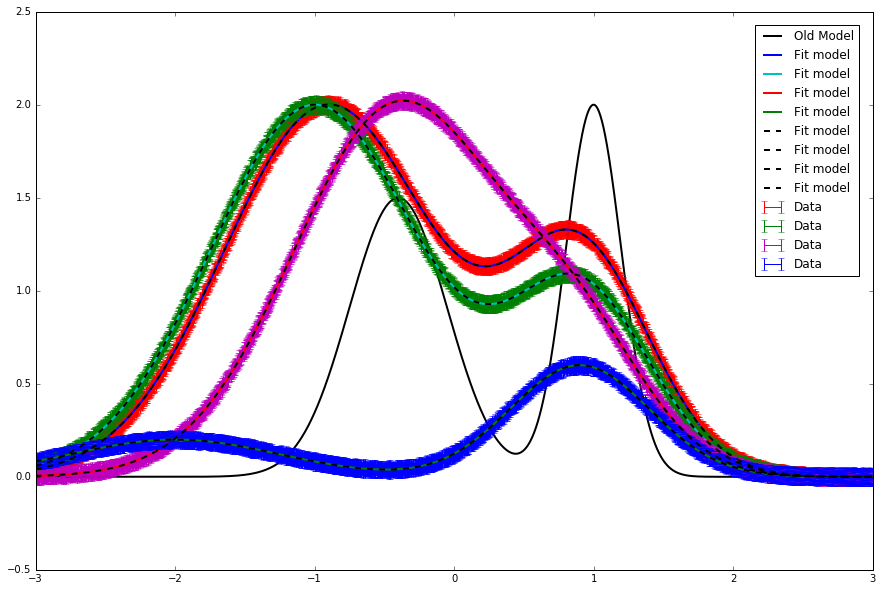

In [123]:
plt.rcParams['figure.figsize']=(15,10)
plt.ion()
plt.plot(x, model(x), lw=2, label="Old Model", c="k")
colcycle = cycle(['r', 'b', 'g', 'c', 'm'])
for yy,yee in zip(y,yerrs):
    fitmodel = sfit(model, x, yy,yerr=yee)
    plt.errorbar(x, yy, label="Data", c=colcycle.next(),yerr=yee)
    plt.plot(x, fitmodel(x),lw=2, label="Fit model", c=colcycle.next())
plt.legend()


xx = np.vstack([x for _ in xrange(len(y))])
fitmodel = sfit(model, xx, y,yerr=yerrs)
plt.plot(np.array(xx).T, fitmodel(x).T, lw=2, ls="--", label="Fit model", c='k')
plt.legend(loc=(0.86,0.527))


In [124]:
err_res2=sfit.est_errors()
err_res=sfit.est_errors(sigma=10)

{'sigma': 1, 'maxiters': 200, 'soft_limits': False, 'eps': 0.01}
{'sigma': 10, 'maxiters': 200, 'soft_limits': False, 'eps': 0.01}


In [125]:
err_vals=defaultdict(list)
for pname,minmax in zip([pname.split(".")[-1] for pname in err_res.parnames],zip(err_res.parmins,err_res.parmaxes)):
    err_vals[pname].append(minmax)

In [126]:
ppnn=[]
ppmm=[]

for sss in fitmodel._param_metrics:
    ppnn.append([nn for nn,mm in err_vals[sss]])
    ppmm.append([mm for nn,mm in err_vals[sss]])

In [158]:
fitmodmins=fitmodel.copy()
fitmodmaxs=fitmodel.copy()

#print np.vstack(zip(fitmodmins._parameters,fitmodmaxs._parameters))
fitmodmins._parameters+=10*np.hstack(ppnn)
fitmodmaxs._parameters+=10*np.hstack(ppmm)
#print np.vstack(zip(fitmodmins._parameters,fitmodmaxs._parameters))


[[ 1.2   1.2 ]
 [ 1.    1.  ]
 [ 0.6   0.6 ]
 [ 0.6   0.6 ]
 [ 2.    2.  ]
 [ 2.    2.  ]
 [ 2.    2.  ]
 [ 0.2   0.2 ]
 [ 0.9   0.9 ]
 [ 0.9   0.9 ]
 [ 0.9   0.9 ]
 [ 0.9   0.9 ]
 [-0.9  -0.9 ]
 [-1.   -1.  ]
 [-0.4  -0.4 ]
 [-2.   -2.  ]
 [ 0.5   0.5 ]
 [ 0.5   0.5 ]
 [ 0.5   0.5 ]
 [ 0.5   0.5 ]
 [ 0.75  0.75]
 [ 0.75  0.75]
 [ 0.75  0.75]
 [ 0.75  0.75]]
[[ 1.19746613  1.20253387]
 [ 0.99505602  1.00494398]
 [ 0.57956646  0.62043354]
 [ 0.59816778  0.60183222]
 [ 1.99618168  2.00381832]
 [ 1.99760169  2.00239831]
 [ 1.97537234  2.02462766]
 [ 0.19665807  0.20334193]
 [ 0.89896674  0.90103326]
 [ 0.89766054  0.90233946]
 [ 0.89446742  0.90553258]
 [ 0.87915901  0.92084099]
 [-0.90115455 -0.89884545]
 [-1.00276942 -0.99723058]
 [-0.4136697  -0.3863303 ]
 [-2.00277768 -1.99722232]
 [ 0.49770157  0.50229843]
 [ 0.49876555  0.50123445]
 [ 0.48865861  0.51134139]
 [ 0.49708673  0.50291327]
 [ 0.74849418  0.75150582]
 [ 0.74684168  0.75315832]
 [ 0.73875258  0.76124742]
 [ 0.72876145  0.7

1.200000.2 (-4e-05 -4e-04) (4e-04 4e-04)
0.900000.2 (-3e-05 -3e-04) (3e-04 3e-04)
0.500000.2 (-1e-05 -1e-04) (1e-04 1e-04)
2.000000.2 (-2e-05 -2e-04) (2e-04 2e-04)
-0.900000.2 (-2e-05 -2e-04) (2e-04 2e-04)
0.750000.2 (-1e-05 -1e-04) (1e-04 1e-04)
1.000000.2 (-2e-05 -2e-04) (2e-04 2e-04)
0.900000.2 (-5e-05 -5e-04) (5e-04 5e-04)
0.500000.2 (-3e-05 -3e-04) (3e-04 3e-04)
2.000000.2 (-1e-05 -1e-04) (1e-04 1e-04)
-1.000000.2 (-3e-05 -3e-04) (3e-04 3e-04)
0.750000.2 (-2e-05 -2e-04) (2e-04 2e-04)
0.600000.2 (-2e-04 -2e-03) (2e-03 2e-03)
0.900000.2 (-2e-04 -2e-03) (2e-03 2e-03)
0.500000.2 (-1e-04 -1e-03) (1e-03 1e-03)
2.000000.2 (-1e-04 -1e-03) (1e-03 1e-03)
-0.400000.2 (-1e-04 -1e-03) (1e-03 1e-03)
0.750000.2 (-6e-05 -6e-04) (6e-04 6e-04)
0.600000.2 (-3e-05 -3e-04) (3e-04 3e-04)
0.900000.2 (-2e-05 -2e-04) (2e-04 2e-04)
0.500000.2 (-3e-05 -3e-04) (3e-04 3e-04)
0.200000.2 (-3e-05 -3e-04) (3e-04 3e-04)
-2.000000.2 (-2e-04 -2e-03) (2e-03 2e-03)
0.750000.2 (-2e-04 -2e-03) (2e-03 2e-03)


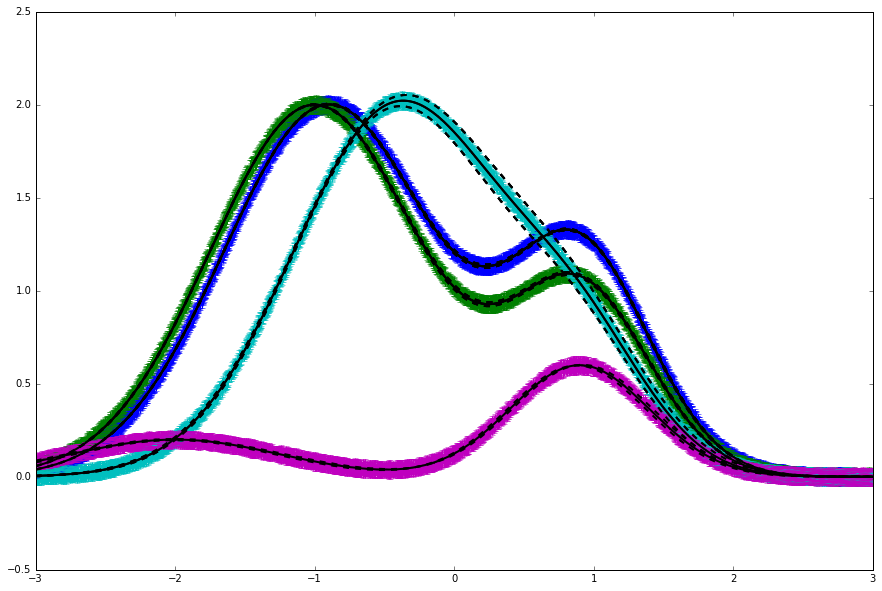

In [160]:
for x,yy,yee in zip(xx,y,yerrs):
    plt.errorbar(x, yy, label="Data", c=colcycle.next(),yerr=yee)
    plt.plot(np.array(xx).T, fitmodel(x).T, lw=2, label="Fit model", c='k')
    plt.plot(np.array(xx).T, fitmodmins(x).T, lw=2, ls="--", label="Min model", c='k')
    plt.plot(np.array(xx).T, fitmodmaxs(x).T, lw=2, ls="--", label="Max model", c='k')

for (p1,l1,h1),(p2,l2,h2) in zip(zip(err_res2.parvals,err_res2.parmins,err_res2.parmaxes),zip(err_res.parvals,err_res.parmins,err_res.parmaxes)):
    print "%f.2 (%.0e %.0e) (%.0e %.0e)" % (p1,l1,l2,h2,h2)